ECE 5460, Au23

Solution for PyTorch Tutorial - final model only

In [10]:
# Task name.
# By: Zhenyu Bu (BME) and Yijing Liu (ECE)

import os
import wandb
task_name = "final_results"

save_path = os.path.join('./results', task_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

norm_mean = [0.485, 0.456, 0.406]  # mean
norm_std = [0.229, 0.224, 0.225]  # std

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

batch_size = 512

ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# spliting training into train and validation
generator = torch.Generator().manual_seed(5460)
(trainset, valset) = torch.utils.data.random_split(ds, [0.8, 0.2], generator=generator)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We will use a convolutional network for classification.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # resnet design
        out = self.relu(out)
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = Block(3, 64, stride=1)
        self.layer2 = Block(64, 128, stride=2)
        self.layer3 = Block(128, 256, stride=2)
        self.layer4 = Block(256, 512, stride=2)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
       
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = Net()

Define a loss function and optimizer

In [ ]:
import torch.optim as optim

num_epochs = 200
lr = 0.1
momentum = 0.9
weight_decay = 5e-4

run = wandb.init(
    project="cifar10",
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "momentum": momentum,
        "weight_decay": weight_decay
    },
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) #Experiment with momentum term and other learning rates

scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                   milestones=[int(num_epochs * 0.56), int(num_epochs * 0.78)],
                   gamma=0.1, last_epoch=-1)

Define training function

In [14]:
def train_step(model, inputs, labels):
  # zero the parameter gradients
  optimizer.zero_grad()

  # forward call
  outputs = model(inputs)

  # calculate loss
  loss = criterion(outputs, labels)

  # back propagation and optimization
  loss.backward()
  optimizer.step()

  return loss

Define evaluation function

Same can be used for testing

In [15]:
def val_step(model, inputs, labels):
  # get inputs and labels from given batch
  with torch.no_grad():
    outputs = model(inputs)

    # calculate the predicted class
    _, predicted = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)
    correct_pred = (predicted == labels).sum().item() # correctly classified samples of the current batch
  return correct_pred, loss

Main training and validation

In [16]:
import time
# num_epochs = 100 # change this to a larger number to train the final network


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print("using device: ", device)


model = model.to(device)

val_acc_log = []
val_loss_log = []

for i in range(num_epochs):
  running_loss = 0
  correct_train_pred = 0
  total_loss = 0
  for j, batch in enumerate(trainloader):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # training step
    loss = train_step(model, inputs, labels)
    running_loss += loss.item()
    total_loss += loss.item()

    # calculate the predicted class
    _, predicted = torch.max(model(inputs).data, 1)
    correct_train_pred += (predicted == labels).sum().item()

    # print some statistics
    if (j+1) % 1000 == 0 :
      print("epoch {}, step = {}, running loss = {:.4f}".format(i, str(j+1).zfill(5), running_loss / 1000))
      running_loss = 0

  train_acc = correct_train_pred / len(trainset)
  train_loss = total_loss / len(trainloader)
  print("epoch {}, training accuracy: {:.2f}%, training loss: {:.4f}".format(i, 100*train_acc, train_loss))
  wandb.log({"train_accuracy": train_acc, "train_loss": train_loss})



  # validation at the end of each epoch
  total_correct_pred = 0
  val_loss = []
  for _, batch in enumerate(valloader):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    curr_correct_pred, curr_loss = val_step(model, inputs, labels)

    # keep track of corrected samples and loss
    total_correct_pred += curr_correct_pred
    val_loss.append(curr_loss.item())

  val_loss = torch.Tensor(val_loss).mean()
  acc = total_correct_pred / len(valset)
  print("val accuracy: {:.2f}, avg loss = {:.3f}".format(100*acc, val_loss))
  val_acc_log.append(acc * 100)
  val_loss_log.append(val_loss.item())

  wandb.log({"val_accuracy": acc, "val_loss": val_loss.item()})

  # save the checkpoint
  torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, './results/{}/epoch_{}_val_acc_{:.2f}.pt'.format(task_name, i, 100*acc))
scheduler.step()
print('\t last_lr:', scheduler.get_last_lr())


using device:  cuda:1


epoch 0, training accuracy: 43.04%, training loss: 1.6400
val accuracy: 46.67, avg loss = 1.473
epoch 1, training accuracy: 59.83%, training loss: 1.1875
val accuracy: 60.04, avg loss = 1.114
epoch 2, training accuracy: 67.40%, training loss: 0.9943
val accuracy: 64.39, avg loss = 0.999
epoch 3, training accuracy: 72.26%, training loss: 0.8534
val accuracy: 68.62, avg loss = 0.887
epoch 4, training accuracy: 75.52%, training loss: 0.7663
val accuracy: 74.05, avg loss = 0.737
epoch 5, training accuracy: 79.07%, training loss: 0.6690
val accuracy: 76.23, avg loss = 0.672
epoch 6, training accuracy: 81.48%, training loss: 0.6122
val accuracy: 77.77, avg loss = 0.634
epoch 7, training accuracy: 83.08%, training loss: 0.5629
val accuracy: 78.72, avg loss = 0.619
epoch 8, training accuracy: 84.15%, training loss: 0.5282
val accuracy: 80.36, avg loss = 0.574
epoch 9, training accuracy: 85.69%, training loss: 0.4907
val accuracy: 81.59, avg loss = 0.520
epoch 10, training accuracy: 86.81%, tra

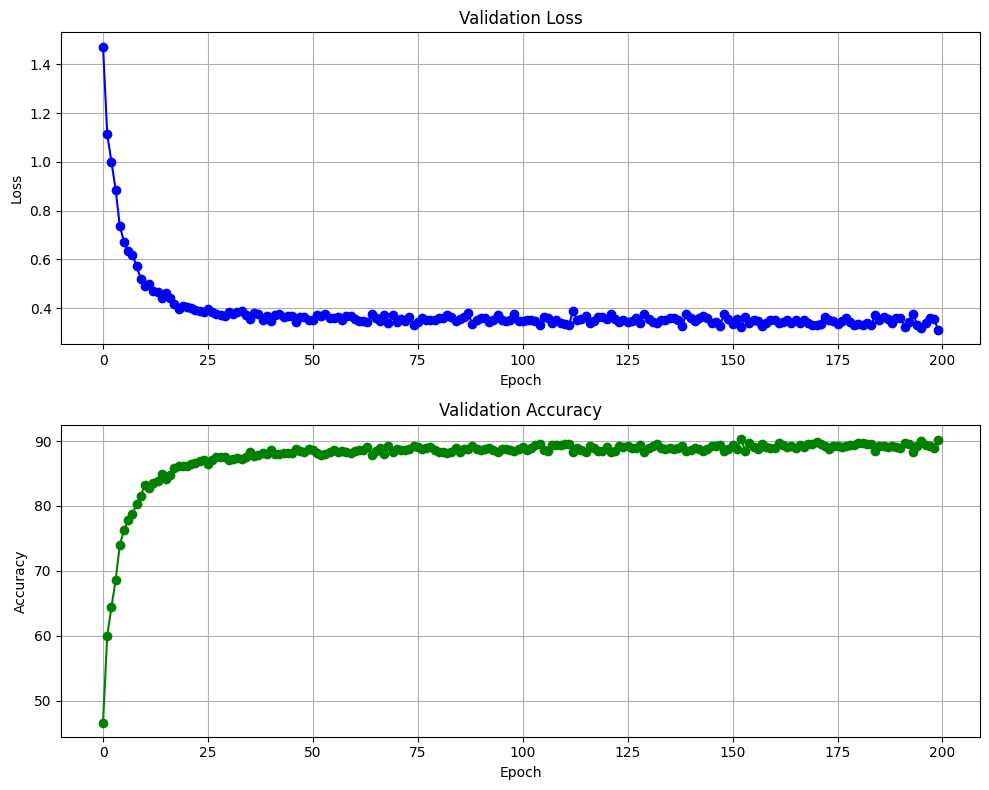

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(val_loss_log, val_acc_log):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    
    ax[0].plot(val_loss_log, marker='o', linestyle='-', color='b')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Validation Loss')
    ax[0].grid(True)
    
    ax[1].plot(val_acc_log, marker='o', linestyle='-', color='g')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_metrics(val_loss_log, val_acc_log)

Testing

The other things to do is to calculate the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to see the accuracy of individual classes.

In [22]:
class_correct = [0. for _ in range(10)]
class_total = [0. for _ in range(10)]

total_correct_pred = 0

for i, batch in enumerate(testloader):
  inputs, labels = batch
  inputs = inputs.to(device)
  labels = labels.to(device)

  curr_correct_pred, _ = val_step(model, inputs, labels)

  # adding up correctly predicted samples
  total_correct_pred += curr_correct_pred

  # calculate the predicted class
  _, predicted = torch.max(model(inputs).data, 1)
  c = (predicted == labels).squeeze()
  for j in range(len(labels)):
    label = labels[j]
    class_correct[label] += c[j].item()
    class_total[label] += 1

# total accuracy
acc = total_correct_pred / len(testloader.dataset)
print("Testing accuracy: {:.2f}%".format(100 * acc))

# accuracy for each class
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
    classes[i], 100 * class_correct[i] / class_total[i]))

Testing accuracy: 88.55%
Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 81 %
Accuracy of   cat : 78 %
Accuracy of  deer : 89 %
Accuracy of   dog : 83 %
Accuracy of  frog : 91 %
Accuracy of horse : 91 %
Accuracy of  ship : 92 %
Accuracy of truck : 92 %


Confusion Matrix:
[[913   6  17   7   7   2   3   1  31  13]
 [ 13 941   0   2   0   0   0   1  10  33]
 [ 28   1 817  42  47  21  21  15   3   5]
 [ 25   8  23 780  29  89  18  16   4   8]
 [ 13   1  18  14 891  20   9  29   1   4]
 [  4   2  22  88  17 837   6  20   0   4]
 [  7   1  14  33  16   8 914   2   2   3]
 [ 13   1  16  20  15  18   1 912   2   2]
 [ 34   7   5   7   1   0   2   2 929  13]
 [ 18  36   1   3   0   0   1   4  16 921]]


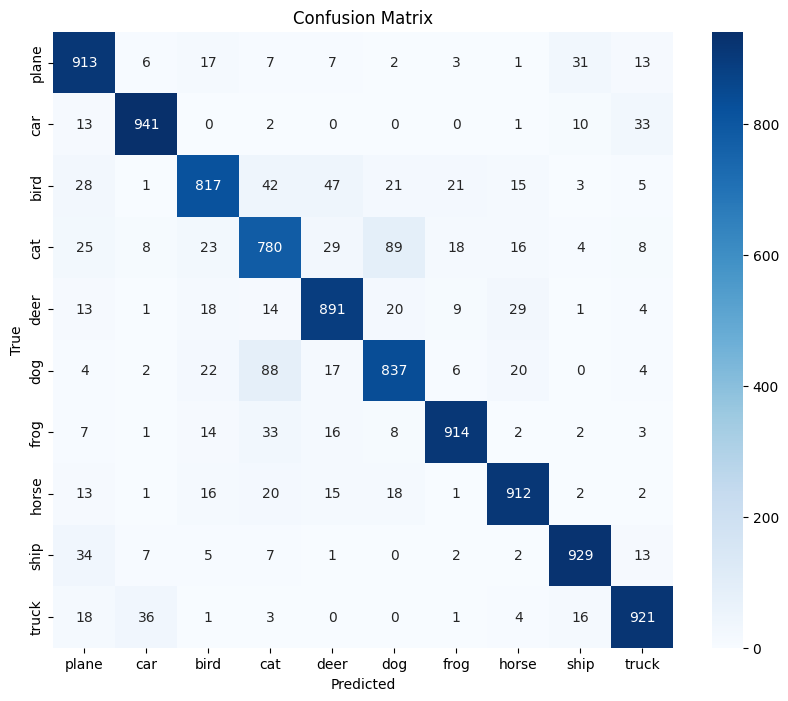

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Initialize the ground truth and predicted labels lists
all_labels = []
all_preds = []

# Iterate through the test loader to get all predictions and true labels
for batch in testloader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(predicted.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

print("Confusion Matrix:")
print(conf_matrix)
import matplotlib.pyplot as plt
# Save the confusion matrix as an image file
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
save_path = './results/{}'.format(task_name)
plt.savefig(os.path.join(save_path, 'confusion_matrix.png'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5255773..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6555357..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1595641..2.11191].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.78291327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6301525.

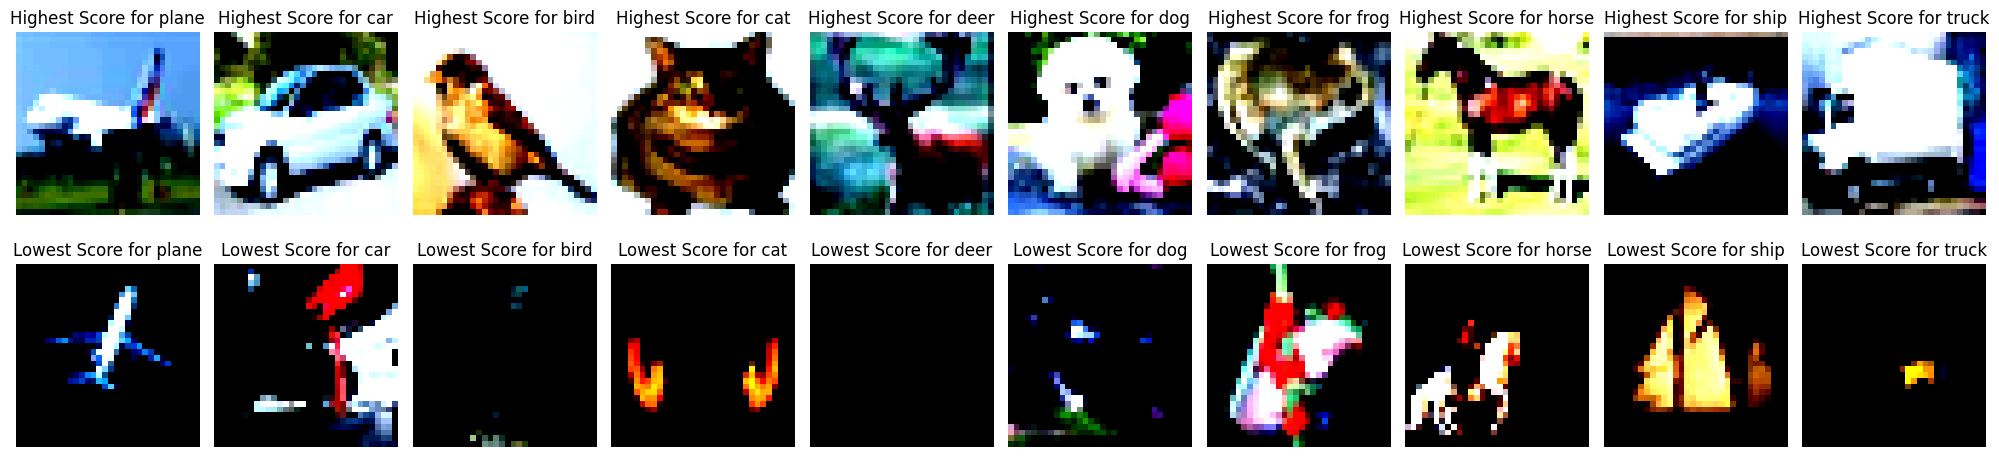

In [36]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store highest and lowest scores and corresponding images
highest_scores = {i: float('-inf') for i in range(10)}
lowest_scores = {i: float('inf') for i in range(10)}
highest_images = {i: None for i in range(10)}
lowest_images = {i: None for i in range(10)}

# Iterate through the test loader to find the highest and lowest scores for each class
for batch in testloader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        scores, predicted = torch.max(outputs.data, 1)

    for i in range(len(labels)):
        label = labels[i].item()
        score = scores[i].item()
        image = inputs[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format for visualization

        if score > highest_scores[label]:
            highest_scores[label] = score
            highest_images[label] = image

        if score < lowest_scores[label]:
            lowest_scores[label] = score
            lowest_images[label] = image

# Plot the highest and lowest score images for each class
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i in range(10):
    axes[0, i].imshow(highest_images[i])
    axes[0, i].set_title(f'Highest Score for {classes[i]}')
    axes[0, i].axis('off')

    axes[1, i].imshow(lowest_images[i])
    axes[1, i].set_title(f'Lowest Score for {classes[i]}')
    axes[1, i].axis('off')

plt.tight_layout()
save_path = './results/{}'.format(task_name)
plt.savefig(os.path.join(save_path, 'highest_lowest_scores.png'))
plt.show()
plt.show()


# By Zhenyu Bu and Yijing Liu